In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import os
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False
)

(x_train, y_train) = train_data.data[:].detach().numpy(), train_data.targets[:].detach().numpy()
(x_test, y_test) = test_data.data[:].detach().numpy(), test_data.targets[:].detach().numpy()

print('Trainning image: ', x_train.shape)
print('Testing image: ', x_test.shape)
print('Training label: ', y_train.shape)
print('Testing label: ', y_test.shape)

Trainning image:  (60000, 28, 28)
Testing image:  (10000, 28, 28)
Training label:  (60000,)
Testing label:  (10000,)


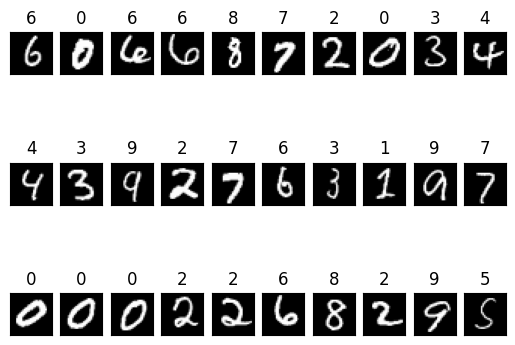

In [3]:
for i in range(30):
    idx = np.random.randint(0, x_train.shape[0])
    image = x_train[idx]
    plt.subplot(3, 10, i + 1)
    plt.imshow(image, cmap = 'gray')
    plt.title(y_train[idx])
    plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
batch_size = 64
num_classes = 10
epochs = 20

img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
print(x_train.shape, y_train.shape)

(60000, 28, 28, 1) (60000,)


In [6]:
class DeepModel(nn.Module):
    def __init__(self, dropout_rate):
        super(DeepModel, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 3, stride = (1, 1), padding = 0, bias = False, dilation = 1)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 3, stride = (1, 1), padding = 0, bias = False, dilation = 1)

        self.dropout = nn.Dropout(dropout_rate)

        self.dense_1 = nn.Linear(12 * 12 * 64, 512)
        self.dense_2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.conv_1(x)
        x = nn.ReLU(inplace = True)(x)
        x = self.conv_2(x)
        x = nn.ReLU(inplace = True)(x)
        x = nn.MaxPool2d(kernel_size = 2)(x)

        x = x.reshape(x.size(0), -1)
        x = self.dense_1(x)
        x = nn.ReLU(inplace = True)(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        
        output = F.log_softmax(x)

        return output

In [7]:
simple_model = DeepModel(dropout_rate = 0.5).cuda()

for param in simple_model.parameters():
    if param.requires_grad:
        print('param autograd')
        break

input = torch.rand(2, 28, 28, 1).cuda()
output = simple_model(input)

model_parameters = filter(lambda p: p.requires_grad, simple_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameter:', params)

param autograd
Number of parameter: 4742954


In [8]:
class Generator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return self.images.shape[0]
        
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [9]:
training_data = Generator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)

test_data = Generator(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = True)

In [10]:
use_cuda = torch.cuda.is_available()
best_loss = float('inf')

model = DeepModel(dropout_rate = 0)

optimizer = torch.optim.Adam(model.parameters())

if use_cuda:
    model = torch.nn.parallel.DataParallel(model.cuda()) 
    torch.backends.cudnn.benchmark = True

In [11]:
def train(model, optimizer, epoch, writer):
    print('\n ############################# Train phase, Epoch: {}, #############################'.format(epoch))
    
    model.train()
    train_loss = 0
    running_loss = 0

    print('\nLearning rate at this epoch is: ', optimizer.param_groups[0]['lr'], '\n')

    for (batch_idx, target_tuple) in enumerate(train_dataloader):
        if use_cuda:
            target_tuple = [target_tensor.cuda(non_blocking = True) for target_tensor in target_tuple]

        images, labels = target_tuple
        labels = torch.tensor(labels, dtype = torch.long)


        optimizer.zero_grad()
        output_tuple = model(images)

        loss = F.nll_loss(output_tuple, labels).cuda()
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss += loss.item()

        if batch_idx % 50 == 49:
            writer.add_scalar('training loss', running_loss / 50, epoch * len(train_dataloader) + batch_idx)
            running_loss = 0

In [12]:
def test(model, epoch, writer):
    print('\n ############################# Test phase, Epoch: {}, #############################'.format(epoch))

    model.eval()

    with torch.no_grad():
        test_loss = 0
        correct = 0

        for (batch_idx, target_tuple) in enumerate(test_dataloader):
            if use_cuda:
                target_tuple = [target_tensor.cuda(non_blocking = True) for target_tensor in target_tuple]

            images, labels = target_tuple
            labels = torch.tensor(labels,dtype=torch.long)

            output_tuple = model(images)

            _, predicted = torch.max(output_tuple.data, 1)
            correct += (predicted == labels).sum().item()

            loss = F.nll_loss(output_tuple, labels).cuda()
            test_loss += loss.item()

        acc = correct * 100 / len(test_data)
        print('Accuracy:', acc)
        writer.add_scalar('test accuracy', acc, epoch)

In [13]:
def train_and_test(model, optimizer, epoch_num = 5, summary_path = 'runs/mnist_experiment_dropout'):
    writer = SummaryWriter(summary_path)

    for epoch in range(epoch_num):
        train(model, optimizer, epoch, writer)
        test(model, epoch, writer)

In [14]:
train_and_test(model, optimizer, 5, 'runs/mnist_experiment_dropout=0')


 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 98.74

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 98.92

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 98.82

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 3, #############################
Accuracy: 98.97

 ############################# Train phase, Epoch: 4, #############################

Learni

In [15]:
%tensorboard --logdir=runs --port 6008

In [16]:
use_cuda = torch.cuda.is_available()
best_loss = float('inf')

model = DeepModel(dropout_rate = 0.5)

optimizer = torch.optim.Adam(model.parameters())

if use_cuda:
    model = torch.nn.parallel.DataParallel(model.cuda()) 
    torch.backends.cudnn.benchmark = True

In [17]:
train_and_test(model, optimizer, 5, 'runs/mnist_experiment_dropout=0.5')


 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 98.68

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 99.0

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 99.09

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 3, #############################
Accuracy: 99.05

 ############################# Train phase, Epoch: 4, #############################

Learnin

In [23]:
%tensorboard --logdir=runs --port 6009

In [19]:
class SimpleModel(nn.Module):
    def __init__(self, dropout_rate = 0.5, activation = None):
        super(SimpleModel, self).__init__()
        self.dense_1 = nn.Linear(28 * 28, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense_2 = nn.Linear(512, 10)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        if self.activation is not None:
            x = self.activation(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        output = F.log_softmax(x)

        return output

In [20]:
simple_model = SimpleModel().cuda()
for param in simple_model.parameters():
    if param.requires_grad:
        print('param autograd')
        break

input = torch.rand(1, 28, 28).cuda()
output = simple_model(input)

model_parameters = filter(lambda p: p.requires_grad, simple_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters:', params)

param autograd
Number of parameters: 407050


In [21]:
use_cuda = torch.cuda.is_available()
best_loss = float('inf')

simple_model = SimpleModel()

optimizer = torch.optim.Adam(simple_model.parameters())

if use_cuda:
    simple_model = torch.nn.parallel.DataParallel(simple_model.cuda()) 
    torch.backends.cudnn.benchmark = True

train_and_test(simple_model, optimizer, 5, 'runs/mnist_none_activation')


 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 90.42

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 92.16

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 91.09

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 3, #############################
Accuracy: 91.9

 ############################# Train phase, Epoch: 4, #############################

Learnin

In [24]:
%tensorboard --logdir=runs --port 6010

In [25]:
for activation in [None, nn.Sigmoid(), nn.Tanh(), nn.ReLU()]:
    print('Activation: ', str(activation))
    simple_model = SimpleModel(dropout_rate = 0.5, activation = activation).cuda()
    optimizer = torch.optim.Adam(simple_model.parameters())

    train_and_test(simple_model, optimizer, 5, 'runs/mnist_' + str(activation))

Activation:  None

 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 91.65

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 91.91

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 91.21

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  0.001 


 ############################# Test phase, Epoch: 3, #############################
Accuracy: 91.98

 ############################# Train phase, Epoch: 4, ###################

In [28]:
%tensorboard --logdir=runs --port 6010

Reusing TensorBoard on port 6010 (pid 9320), started 0:46:57 ago. (Use '!kill 9320' to kill it.)

In [29]:
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]

for lr in learning_rates:
    print('Learning rate = %f' % lr)

    simple_model = SimpleModel(dropout_rate = 0.5, activation = nn.ReLU()).cuda()
    optimizer = torch.optim.SGD(simple_model.parameters(), lr = lr, momentum = 0.9)

    train_and_test(simple_model, optimizer, 5, 'runs/lnr_' + str(lr))

Learning rate = 1.000000

 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  1.0 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 11.35

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  1.0 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 9.82

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  1.0 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 11.35

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  1.0 


 ############################# Test phase, Epoch: 3, #############################
Accuracy: 11.35

 ############################# Train phase, Epoch: 4, #####################

In [30]:
%tensorboard --logdir=runs --port 6010

Reusing TensorBoard on port 6010 (pid 9320), started 0:52:13 ago. (Use '!kill 9320' to kill it.)

In [36]:
def train(model, optimizer, scheduler, epoch, writer):
    print('\n ############################# Train phase, Epoch: {}, #############################'.format(epoch))
    
    model.train()
    train_loss = 0
    running_loss = 0

    print('\nLearning rate at this epoch is: ', scheduler.get_last_lr(), '\n')

    for (batch_idx, target_tuple) in enumerate(train_dataloader):
        if use_cuda:
            target_tuple = [target_tensor.cuda(non_blocking = True) for target_tensor in target_tuple]

        images, labels = target_tuple
        labels = torch.tensor(labels, dtype = torch.long)


        optimizer.zero_grad()
        output_tuple = model(images)

        loss = F.nll_loss(output_tuple, labels).cuda()
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss += loss.item()

        if batch_idx % 50 == 49:
            writer.add_scalar('training loss', running_loss / 50, epoch * len(train_dataloader) + batch_idx)
            running_loss = 0

    scheduler.step()

In [37]:
def train_and_test(model, optimizer, scheduler, epoch_num = 5, summary_path = 'runs/mnist_experiment_dropout'):
    writer = SummaryWriter(summary_path)

    for epoch in range(epoch_num):
        train(model, optimizer, scheduler, epoch, writer)
        test(model, epoch, writer)

In [ ]:
simple_model = SimpleModel(dropout_rate = 0.5, activation = nn.ReLU()).cuda()
optimizer = torch.optim.SGD(simple_model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
train_and_test(simple_model, optimizer, scheduler,  20, 'runs/exponetialLR')


 ############################# Train phase, Epoch: 0, #############################

Learning rate at this epoch is:  [0.01] 


 ############################# Test phase, Epoch: 0, #############################
Accuracy: 94.64

 ############################# Train phase, Epoch: 1, #############################

Learning rate at this epoch is:  [0.009000000000000001] 


 ############################# Test phase, Epoch: 1, #############################
Accuracy: 96.45

 ############################# Train phase, Epoch: 2, #############################

Learning rate at this epoch is:  [0.008100000000000001] 


 ############################# Test phase, Epoch: 2, #############################
Accuracy: 97.14

 ############################# Train phase, Epoch: 3, #############################

Learning rate at this epoch is:  [0.007290000000000001] 

